In [313]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [314]:
# Load the image
boot = cv2.imread('pair_boot.jpg')

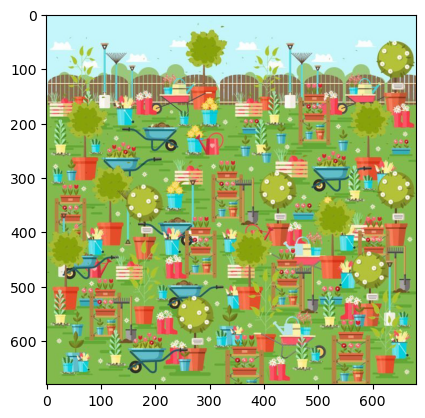

In [315]:
# Show the image
plt.imshow(boot[:,:,::-1])


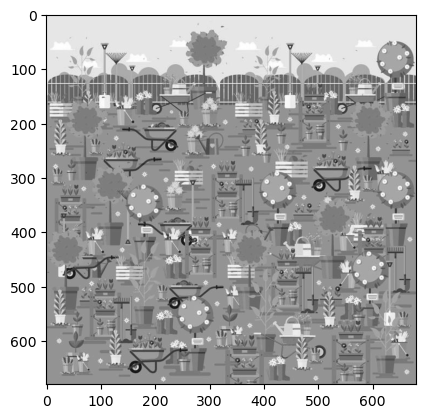

In [316]:
# Convert the image to grayscale
gray_boot = cv2.cvtColor(boot, cv2.COLOR_BGR2GRAY)
# Show the image

plt.imshow(gray_boot, cmap='gray')

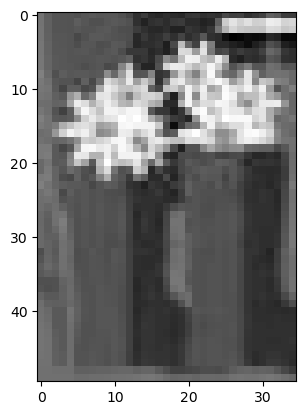

In [317]:
# Get template1
template1 = gray_boot[160:210, 635:670]
plt.imshow(template1, cmap='gray')

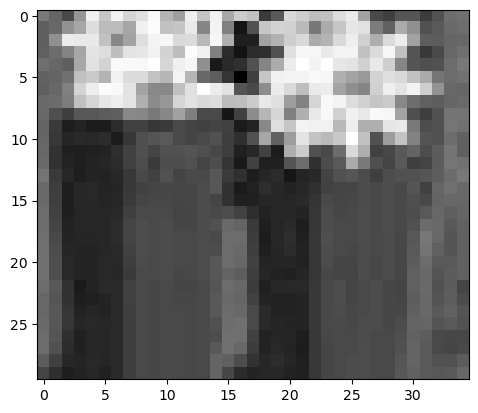

In [318]:
# Get template2
template2 = cv2.flip(template1, 1)
template2 = template2[10:40,:]
plt.imshow(template2, cmap='gray')

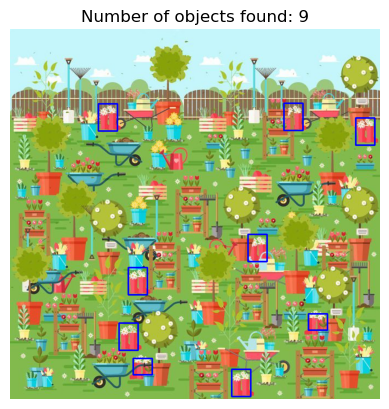

Number of pair boots found: 9


In [319]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for edge detection using Laplacian kernel
def edge_detection(image):
    kernel = np.array(
        [[1, 1, 1],
         [1, -8, 1],
         [1, 1, 1]]
    )
    edges = cv2.filter2D(image, -1, kernel)
    return edges

# Non-Maximum Suppression (NMS)
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
    return boxes[pick].astype("int")

# Count the number of pair_boot with NMS
def count_pair_boot(image, edge_template1, edge_template2, edges):
    # Apply template matching
    res1 = cv2.matchTemplate(edges, edge_template1, cv2.TM_CCOEFF_NORMED)
    res2 = cv2.matchTemplate(edges, edge_template2, cv2.TM_CCOEFF_NORMED)
    
    # Set a threshold
    threshold = 0.35
    
    # Find the location of the pair_boot
    loc1 = np.where(res1 >= threshold)
    loc2 = np.where(res2 >= threshold)
    
    # Collect bounding boxes for loc1 and loc2
    boxes = []
    
    for pt in zip(*loc1[::-1]):
        box = [pt[0], pt[1], pt[0] + edge_template1.shape[1], pt[1] + edge_template1.shape[0]]
        boxes.append(box)
    
    for pt in zip(*loc2[::-1]):
        box = [pt[0], pt[1], pt[0] + edge_template2.shape[1], pt[1] + edge_template2.shape[0]]
        boxes.append(box)
    
    # Convert boxes to numpy array
    boxes = np.array(boxes)

    # Apply non-max suppression
    if len(boxes) > 0:
        boxes = non_max_suppression(boxes, overlapThresh=0.3)

    # Draw rectangles for remaining boxes
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Show the image with bounding boxes
    plt.imshow(image[:,:,::-1])
    plt.title(f'Number of objects found: {len(boxes)}')
    plt.axis('off')
    plt.show()
    
    return len(boxes)

# Apply edge detection to the original image and templates
edges = edge_detection(cv2.cvtColor(boot, cv2.COLOR_BGR2GRAY))
edges_template1 = edge_detection(template1)
edges_template2 = edge_detection(template2)

# Count the number of pair_boot
count = count_pair_boot(boot, edges_template1, edges_template2, edges)
print(f"Number of pair boots found: {count}")
